In [67]:
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import random

# Load the wine dataset
data = load_wine()
X = data.data  # Features (178, 13)
y = data.target  # Labels (178,)

# two classes
X = X[:130]
y = y[:130]

# standardize input data
scaler = StandardScaler()
X = scaler.fit_transform(X)
log_reg = LogisticRegression(penalty=None, max_iter=100000)
log_reg.fit(X, y)
y_train_pred_proba = log_reg.predict_proba(X)
L = log_loss(y, y_train_pred_proba)
print(f"Final loss (log loss) on the training set: {L:.4f}")


Final loss (log loss) on the training set: 0.0003


In [65]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_function(X, y, weight):
    m = len(y)
    y_hat = sigmoid(X @ weight)
    loss = -(1/m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return loss

def gradient(X, y, weight):
    m = len(y)
    y_hat = sigmoid(X @ weight)
    grad = (1/m) * X.T @ (y_hat - y)
    return grad

def logistic_regression_random(X, y, weight, alpha, iterations):
    losses = []
    for i in range(iterations):
        dim_choice = random.choice(range(X.shape[1])) # 1-13 because the 0 dimension is 1
        grad = gradient(X, y, weight)
        weight[dim_choice] = weight[dim_choice] - alpha * grad[dim_choice]
        losses.append(loss_function(X, y, weight))
    return weight, losses

m, n = X.shape
X_with_intercept = np.hstack((np.ones((m, 1)), X)) # add 1 for b
initial_weight = np.zeros(n + 1)
alpha = 0.9
iterations = 100000

weight_optimal, losses_random = logistic_regression_random(X_with_intercept, y, initial_weight, alpha, iterations)

print("Optimal coefficients:", weight_optimal)
print("loss:", losses_random[-1])

Optimal coefficients: [-0.01792338 -4.70633785 -1.74004292 -3.5872153   4.50777682 -0.57292254
  0.07542377 -1.13265492  0.48909318  0.50665059 -1.92568887  0.41958137
 -2.09826473 -6.37411061]
loss: 0.0005965297376903301


In [62]:
def logistic_regression_max_gradient(X, y, weight, alpha, iterations):
    losses = []
    for i in range(iterations):
        grad = gradient(X, y, weight)
        dim_choice = np.where(np.abs(grad) == max(np.abs(grad)))[0]
        weight[dim_choice] = weight[dim_choice] - alpha * grad[dim_choice]
        losses.append(loss_function(X, y, weight))
    return weight, losses


m, n = X.shape
X_with_intercept = np.hstack((np.ones((m, 1)), X)) # add 1 for b
initial_weight = np.zeros(n + 1)
alpha = 0.9
iterations = 100000

weight_optimal, losses_maxgrad = logistic_regression_max_gradient(X_with_intercept, y, initial_weight, alpha, iterations)

print("Optimal coefficients:", weight_optimal)
print("loss:", losses_maxgrad[-1])

Optimal coefficients: [ 0.         -5.64246563 -1.84333424 -3.99312015  4.87637701  0.
  0.         -1.7409481   0.          0.         -0.97591628  0.52823275
 -2.09433398 -8.31994315]
loss: 0.00027376625605959485


In [63]:
def hessian(X, y, weight):
    m = len(y)
    y_hat = sigmoid(X @ weight)
    P = np.diag(y_hat)
    hessian = (1/m) * (-X.T) @ (P - P**2) @ X
    return hessian
X_with_intercept = np.hstack((np.ones((m, 1)), X)) # add 1 for b
initial_weight = np.zeros(n + 1)
np.diag(hessian(X_with_intercept, y, initial_weight)).shape
def logistic_regression_max_second_deri(X, y, weight, alpha, iterations):
    hessian_diag = np.diag(hessian(X, y, weight)) # doesn't change much during gradient descent
    sorted_indices = np.argsort([second for second in -np.abs(hessian_diag)])
    choose_from = [] # imbalanced list to perform random choice which favors dimensions with high hessian
    for j in range(7):
        for _ in range(7-j):
            choose_from.append(sorted_indices[2*j])
            choose_from.append(sorted_indices[2*j+1])
    losses = []
    for i in range(iterations):
        grad = gradient(X, y, weight)
        dim_choice = random.choice(choose_from)
        weight[dim_choice] = weight[dim_choice] - alpha * grad[dim_choice]
        losses.append(loss_function(X, y, weight))
    return weight, losses


m, n = X.shape
X_with_intercept = np.hstack((np.ones((m, 1)), X)) # add 1 for b
initial_weight = np.zeros(n + 1)
alpha = 0.9
iterations = 100000

weight_optimal, losses_maxsecond = logistic_regression_max_second_deri(X_with_intercept, y, initial_weight, alpha, iterations)

print("Optimal coefficients:", weight_optimal)
losses_maxsecond[-1]

Optimal coefficients: [-0.14999323 -3.45702377 -2.25081477 -2.17967212  3.91050045 -0.416188
 -0.25939618 -0.64857595 -1.26420021  0.45085654 -2.51001596  0.31635443
 -3.04007468 -8.57903303]


0.0007670653850784887

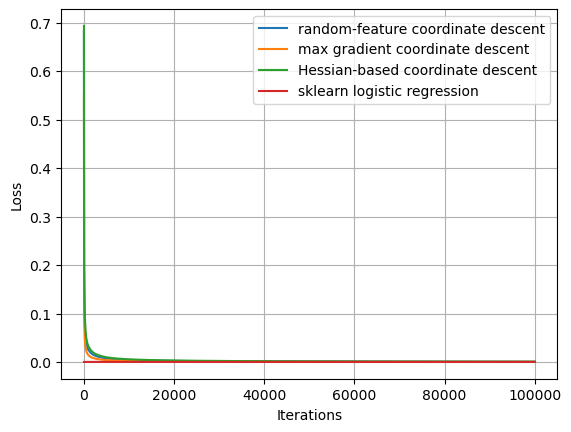

In [66]:
plt.plot(range(100000), losses_random, label = 'random-feature coordinate descent')
plt.plot(range(100000), losses_maxgrad, label = 'max gradient coordinate descent')
plt.plot(range(100000), losses_maxsecond, label = 'Hessian-based coordinate descent')
plt.plot(range(100000), np.array([L]*100000), label = 'sklearn logistic regression')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig("coordinate-descent.png")
plt.show()